In [1]:
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from functools import partial
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device=='cuda':
    n = torch.cuda.current_device()
    print(torch.cuda.get_device_name(n))

In [3]:
device

device(type='cuda')

In [4]:
class LidarDataset(Dataset):
  def __init__(self, filename, transform=None):
    self.data = pd.read_csv(filename)
    self.data.drop(columns=self.data.columns[0], axis=1, inplace=True)
    print(self.data.head(18))
    print(f'NaN values: {self.data.isna().sum().sum()}')
    self.X = self.data.iloc[1:, 3:].values
    self.y = self.data.iloc[1:, :3].values
    self.X = torch.tensor(self.X, dtype=torch.float32)
    self.y = torch.tensor(self.y, dtype=torch.float32)
    self.transform = transform

  def __getitem__(self, index):
    return self.X[index], self.y[index]

  def __len__(self):
    return len(self.y)

In [5]:
transform = transforms.Compose([transforms.ToTensor, transforms.Normalize([0.5], [0.5], [0.5])])

In [6]:
lidar_dataset = LidarDataset('/content/drive/MyDrive/igrovi/image_dset_output_wthcoords.csv', transform=transform)

             x           y  player_angle    0    1    2    3    4    5    6  \
0   640.000000  360.000000          -0.7  0.5  0.5  0.5  0.5  0.5  0.5  0.5   
1   640.000000  360.000000          -0.8  0.5  0.5  0.5  0.5  0.5  0.5  0.5   
2   640.000000  360.000000          -0.9  0.5  0.5  0.5  0.5  0.5  0.5  0.5   
3   640.000000  360.000000          -1.0  0.5  0.5  0.5  0.5  0.5  0.5  0.5   
4   640.000000  360.000000          -1.1  0.5  0.5  0.5  0.5  0.5  0.5  0.5   
5   640.000000  360.000000          -1.2  0.5  0.5  0.5  0.5  0.5  0.5  0.5   
6   640.000000  360.000000          -1.3  0.5  0.5  0.5  0.5  0.5  0.5  0.5   
7   640.000000  360.000000          -1.4  0.5  0.5  0.5  0.5  0.5  0.5  0.5   
8   640.000000  360.000000          -1.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5   
9   640.000000  360.000000          -1.6  0.5  0.5  0.5  0.5  0.5  0.5  0.5   
10  639.859842  355.202047          -1.6  0.5  0.5  0.5  0.5  0.5  0.5  0.5   
11  639.710925  350.104221          -1.6  0.5  0.5  

In [7]:
lidar_train, lidar_test = random_split(lidar_dataset, [0.8, 0.2])
train_loader = DataLoader(dataset=lidar_train, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=lidar_test, batch_size=100, shuffle=True)
print(f'Training records: {len(train_loader.dataset)} Testing records: {len(test_loader.dataset)}')

Training records: 1780 Testing records: 444


In [8]:
next(iter(train_loader))[0][0].resize_(100, 100).shape

torch.Size([100, 100])

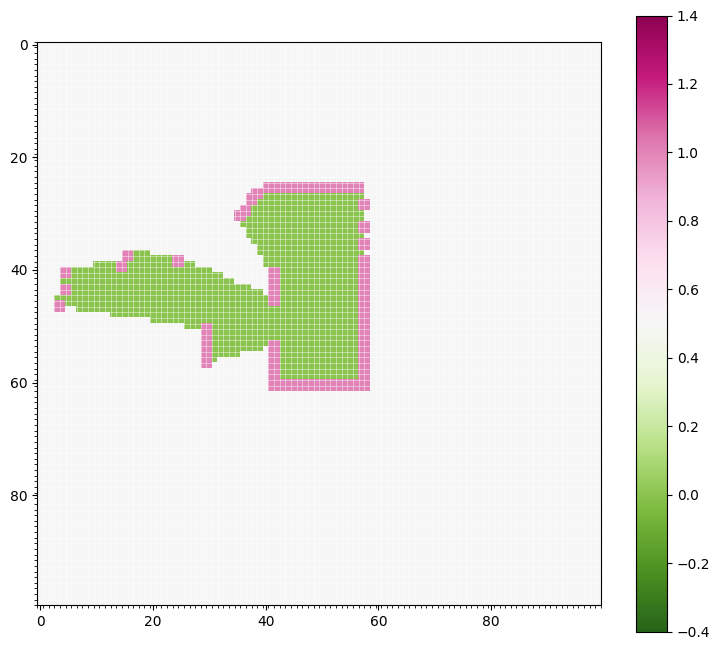

KeyboardInterrupt: ignored

In [9]:
for i in iter(train_loader):
    for j in range(100):
        img = i[0][j].resize_(100, 100)
        # img = next(iter(train_loader))[0][10].resize_(100, 100)

        xyres = np.array(img).shape
        plt.figure(figsize=(20,8))
        plt.subplot(122)
        plt.imshow(img, cmap = "PiYG_r")
        plt.clim(-0.4, 1.4)
        plt.gca().set_xticks(np.arange(-.5, xyres[1], 1), minor = True)
        plt.gca().set_yticks(np.arange(-.5, xyres[0], 1), minor = True)
        plt.grid(True, which="minor", color="w", linewidth = .6, alpha = 0.5)
        plt.colorbar()
        plt.show()

In [9]:
class SimpleNN(nn.Module):
  def __init__(self, input_size, output_size, *layer_size):
    super(SimpleNN, self).__init__()
    self.relu = nn.ReLU()
    self.layers = nn.ModuleList()
    self.layers.append(nn.Linear(input_size, layer_size[0]))
    for i in range(1, len(layer_size)):
      self.layers.append(nn.Linear(layer_size[i-1], layer_size[i]))
    self.layers.append(nn.Linear(layer_size[-1], output_size))

  def forward(self, x):
    for i in range(len(self.layers)):
      x = self.layers[i](x)
      if i < len(self.layers) - 1:
        x = self.relu(x)
    return x

In [10]:
model_1 = SimpleNN(90, 3, 360, 180, 45)
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model_1)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
| layers.0.weight |   32400    |
|  layers.0.bias  |    360     |
| layers.1.weight |   64800    |
|  layers.1.bias  |    180     |
| layers.2.weight |    8100    |
|  layers.2.bias  |     45     |
| layers.3.weight |    135     |
|  layers.3.bias  |     3      |
+-----------------+------------+
Total Trainable Params: 106023


106023

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1, padding=0)
        self.max_pool = nn.MaxPool2d(kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=6 * 15 * 15, out_features=4*4*5)
        self.fc2 = nn.Linear(in_features=4*4*5, out_features=4*6)
        self.fc3 = nn.Linear(in_features=4*6, out_features=3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = x.view(-1, 6 * 15 * 15)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


In [12]:
def test_model(model, criterion, dataloader, gpu=None):
  with torch.no_grad():
    avg_test_loss = 0
    for (x, y) in dataloader:
      x = x.view(-1, 100, 100)
      x = x.unsqueeze(dim=1)
      if (gpu is not None):
        x, y = x.to(gpu), y.to(gpu)
      preds = model(x)
      avg_test_loss += criterion(preds, y)
    avg_test_loss /= len(dataloader.dataset)
    return avg_test_loss

In [13]:
def train_model(model, optimizer, criterion, epochs, train_loader, test_loader, gpu=None):
  time1 = time.time()
  train_loss_history, val_loss_history = [], []
  for epoch in range(epochs):
    epoch_loss = None
    for i, (x, y) in enumerate(train_loader):
      x = x.view(-1, 100, 100)
      x = x.unsqueeze(dim=1)
      if (gpu is not None):
        x, y = x.to(gpu), y.to(gpu)
      preds = model(x)
      loss = criterion(preds, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_loss = loss.item()
    if (epoch + 1) % 1 == 0:
      train_loss_history.append(epoch_loss)
    #   print(epoch_loss)
      val_loss_history.append(test_model(model, criterion, test_loader, gpu))
      if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch + 1} of {epochs}: Train Loss = {epoch_loss:.4f} Val Loss = {val_loss_history[-1].cpu()}')
  time2 = time.time()
  print(f'Training Time: {time2 - time1} seconds')
  return train_loss_history, val_loss_history

In [13]:
cpu_net = Net()
criterion = nn.MSELoss()
cpu_optimizer = torch.optim.Adam(cpu_net.parameters(), lr=0.001)
count_parameters(cpu_net)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |     75     |
|  conv1.bias  |     3      |
| conv2.weight |    450     |
|  conv2.bias  |     6      |
|  fc1.weight  |   108000   |
|   fc1.bias   |     80     |
|  fc2.weight  |    1920    |
|   fc2.bias   |     24     |
|  fc3.weight  |     72     |
|   fc3.bias   |     3      |
+--------------+------------+
Total Trainable Params: 110633


110633

In [14]:
losses = train_model(cpu_net, cpu_optimizer, criterion, 250, train_loader, test_loader)

Epoch 5 of 250: Train Loss = 24150.9023 Val Loss = 280.67840576171875
Epoch 10 of 250: Train Loss = 21648.5059 Val Loss = 281.1939697265625
Epoch 15 of 250: Train Loss = 24025.4570 Val Loss = 266.5615234375
Epoch 20 of 250: Train Loss = 22384.2012 Val Loss = 261.8266296386719
Epoch 25 of 250: Train Loss = 21420.9980 Val Loss = 246.40359497070312
Epoch 30 of 250: Train Loss = 19028.4492 Val Loss = 217.5161590576172
Epoch 35 of 250: Train Loss = 13784.0664 Val Loss = 168.50157165527344
Epoch 40 of 250: Train Loss = 10142.1104 Val Loss = 146.36680603027344
Epoch 45 of 250: Train Loss = 10791.7012 Val Loss = 131.6229705810547
Epoch 50 of 250: Train Loss = 7812.4795 Val Loss = 99.25346374511719
Epoch 55 of 250: Train Loss = 4796.7266 Val Loss = 64.14676666259766
Epoch 60 of 250: Train Loss = 4255.2827 Val Loss = 50.557769775390625
Epoch 65 of 250: Train Loss = 3525.9895 Val Loss = 48.69704818725586
Epoch 70 of 250: Train Loss = 3279.8125 Val Loss = 37.21881103515625
Epoch 75 of 250: Train L

In [14]:
def plot_loss(train_loss_history, val_loss_history):
  x = [i for i in range(len(train_loss_history))]
  if val_loss_history[0].device.type != 'cpu':
    val_loss_history = [i.cpu() for i in val_loss_history]
  plt.plot(x, train_loss_history, label='Train Loss')
  plt.legend()
  plt.show()
  plt.plot(x, val_loss_history, label='Val Loss')
  plt.legend()
  plt.show()

In [147]:
len(losses[0])

150

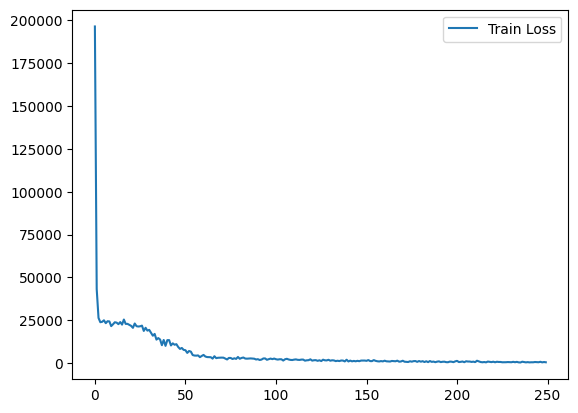

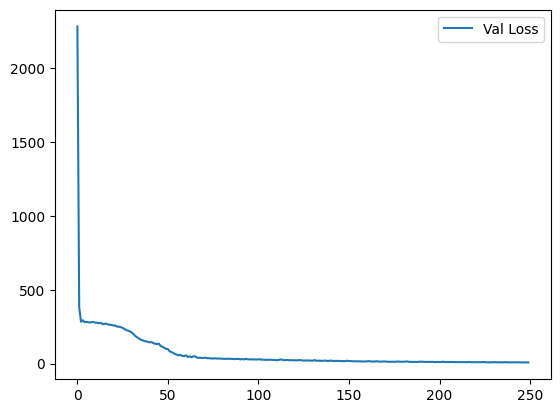

In [18]:
plot_loss(*losses)

In [15]:
gpu_net = Net()
criterion = nn.MSELoss()
gpu_optimizer = torch.optim.Adam(gpu_net.parameters(), lr=0.001)
gpu_net = gpu_net.to(device)
count_parameters(gpu_net)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |     75     |
|  conv1.bias  |     3      |
| conv2.weight |    450     |
|  conv2.bias  |     6      |
|  fc1.weight  |   108000   |
|   fc1.bias   |     80     |
|  fc2.weight  |    1920    |
|   fc2.bias   |     24     |
|  fc3.weight  |     72     |
|   fc3.bias   |     3      |
+--------------+------------+
Total Trainable Params: 110633


110633

In [16]:
losses = train_model(gpu_net, gpu_optimizer, criterion, 250, train_loader, test_loader, gpu=device)

Epoch 5 of 250: Train Loss = 27326.7520 Val Loss = 274.5051574707031
Epoch 10 of 250: Train Loss = 23237.4746 Val Loss = 269.08392333984375
Epoch 15 of 250: Train Loss = 24418.8965 Val Loss = 261.84814453125
Epoch 20 of 250: Train Loss = 21767.5508 Val Loss = 249.81289672851562
Epoch 25 of 250: Train Loss = 21690.2812 Val Loss = 230.03628540039062
Epoch 30 of 250: Train Loss = 16795.0449 Val Loss = 177.54763793945312
Epoch 35 of 250: Train Loss = 8574.2109 Val Loss = 98.2419662475586
Epoch 40 of 250: Train Loss = 3957.0132 Val Loss = 48.023109436035156
Epoch 45 of 250: Train Loss = 2755.4048 Val Loss = 34.04078674316406
Epoch 50 of 250: Train Loss = 2539.7141 Val Loss = 30.16616439819336
Epoch 55 of 250: Train Loss = 2663.3699 Val Loss = 25.96529769897461
Epoch 60 of 250: Train Loss = 1836.0176 Val Loss = 24.571989059448242
Epoch 65 of 250: Train Loss = 1566.4462 Val Loss = 20.68760871887207
Epoch 70 of 250: Train Loss = 1707.0339 Val Loss = 17.119583129882812
Epoch 75 of 250: Train Lo

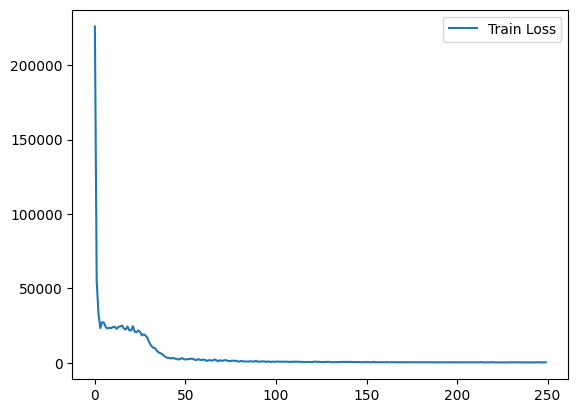

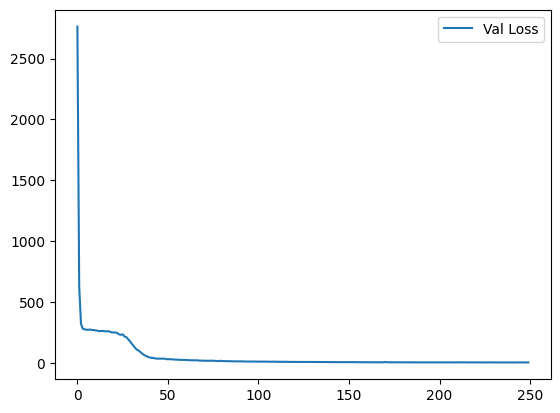

In [17]:
plot_loss(*losses)